In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2004-08-19', '2020-12-24')`.

In [3]:
df = pd.read_csv('Stocks\GOOG.csv')

## Quick look at data

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-22,61.799500,62.454498,61.415501,62.442001,62.442001,16146000
1,2019-04-23,62.534500,63.450001,62.319000,63.227501,63.227501,26398000
2,2019-04-24,63.206001,63.400501,62.750000,62.799999,62.799999,20376000
3,2019-04-25,63.238499,63.370399,62.601501,63.172501,63.172501,22146000
4,2019-04-26,63.450001,63.653500,63.015999,63.609001,63.609001,24828000


In [5]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['Date', 'Close', 'Volume']]

In [6]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183 entries, 0 to 1182
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1183 non-null   object 
 1   Close   1183 non-null   float64
 2   Volume  1183 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 27.9+ KB


**Data Time Period**

In [7]:
df['Date'].min(), df['Date'].max()

('2019-04-22', '2023-12-29')

## Visualize the data

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Google Stock Price 2019-2024')
fig.show()
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df['Date'], y=df['Volume'], name='Volume'))
fig2.update_layout(showlegend=True, title='Google Stock Price 2019-2024')
fig2.show()

## Data Preprocessing

In [9]:
df[['Close','Volume']].head()

,Close,Volume
0,62.442001,16146000
1,63.227501,26398000
2,62.799999,20376000
3,63.172501,22146000
4,63.609001,24828000


In [10]:
scaler = StandardScaler()
scaler = scaler.fit(df[['Close','Volume']])
scaled_train = scaler.transform(df[['Close','Volume']])
#train_df = pd.DataFrame(scaled_train,columns = ['Close','Volume'])

In [11]:
scaled_train[0:5]

array([[-1.3374812 , -1.00458351],
       [-1.31047676, -0.21576535],
       [-1.32517371, -0.67911523],
       [-1.31236759, -0.54292638],
       [-1.2973613 , -0.33656564]])

In [27]:
# scaled_train_df = pd.DataFrame(scaled_train, columns=['Close', 'Volume'])

# #scaled_train_df['Index'] = scaled_train_df.index

# scaled_train_df.head()

In [80]:
def generate_sequences(data, window_size):
  _l = len(data) 
  Xs = []
  Ys = []
  for i in range(0, (_l - window_size)):
    Xs.append(data[i:i+window_size,:])
    #print(data[i+window_size,:])
    Ys.append(data[i+window_size,:][0]) # Here 0 indicates the Close Price Prediction
  return np.array(Xs), np.array(Ys)

In [81]:
TIME_STEPS = 5
X_train, Y_train= generate_sequences(scaled_train, TIME_STEPS)
print("Training input shape: ", X_train.shape)
print("Training input shape: ", Y_train.shape)

Training input shape:  (1178, 5, 2)
Training input shape:  (1178,)


In [82]:
print(X_train[0])

print(X_train[1])

print(X_train[2])

[[-1.3374812  -1.00458351]
 [-1.31047676 -0.21576535]
 [-1.32517371 -0.67911523]
 [-1.31236759 -0.54292638]
 [-1.2973613  -0.33656564]]
[[-1.31047676 -0.21576535]
 [-1.32517371 -0.67911523]
 [-1.31236759 -0.54292638]
 [-1.2973613  -0.33656564]
 [-1.27088983  1.59931661]]
[[-1.32517371 -0.67911523]
 [-1.31236759 -0.54292638]
 [-1.2973613  -0.33656564]
 [-1.27088983  1.59931661]
 [-1.44123606  7.30478326]]


In [83]:
Y_train[0]

-1.2708898267239963

In [84]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

In [85]:
X_train.shape

(1178, 5, 2)

## Build a model

In [87]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(None, X_train.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(rate=0.1))
#model.add(Dense(X_train.shape[2]))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, None, 128)         67072     
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,545
Trainable params: 116,545
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [88]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    #callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                    shuffle=False)

Epoch 1/100
30/30 [==============================] - 6s 55ms/step - loss: 1.0074 - val_loss: 0.6362
Epoch 2/100
30/30 [==============================] - 1s 38ms/step - loss: 0.4324 - val_loss: 0.0946
Epoch 3/100
30/30 [==============================] - 1s 30ms/step - loss: 0.0425 - val_loss: 0.1423
Epoch 4/100
30/30 [==============================] - 1s 33ms/step - loss: 0.1544 - val_loss: 0.0779
Epoch 5/100
30/30 [==============================] - 1s 29ms/step - loss: 0.1480 - val_loss: 0.2987
Epoch 6/100
30/30 [==============================] - 1s 27ms/step - loss: 0.2612 - val_loss: 0.2338
Epoch 7/100
30/30 [==============================] - 1s 29ms/step - loss: 0.1356 - val_loss: 0.0261
Epoch 8/100
30/30 [==============================] - 1s 29ms/step - loss: 0.0608 - val_loss: 0.0272
Epoch 9/100
30/30 [==============================] - 1s 26ms/step - loss: 0.0532 - val_loss: 0.0226
Epoch 10/100
30/30 [==============================] - 1s 26ms/step - loss: 0.0291 - val_loss: 0.0493

#### Plot Training - Validation loss

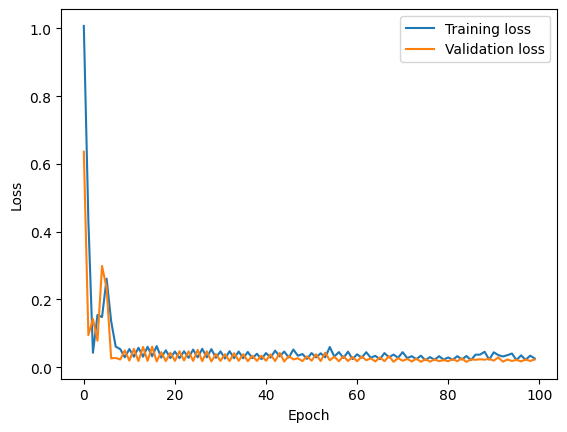

In [89]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [90]:
model.save('saved_models/lstm_shap.h5')

In [91]:
new_df = pd.read_csv('Stocks\Test.csv')
new_df = new_df[['Date','Close','Volume']]
scaled_new_test = scaler.transform(new_df[['Close','Volume']])
X_new, Y_new = generate_sequences(scaled_new_test, TIME_STEPS)
new_test_pred = model.predict(X_new, verbose=1)


3/3 [==============================] - 1s 11ms/step


### TimeSHAP code starts here

In [92]:
import timeshap
import tensorflow as tf
from timeshap.utils import calc_avg_event
from timeshap.utils import calc_avg_sequence
from timeshap.utils import get_avg_score_with_avg_event
from timeshap.explainer import local_report

user_model = tf.keras.models.load_model('saved_models\lstm_shap.h5')
model_features = ['Close', 'Volume']


average_event = calc_avg_event(scaled_train_df, 
                               numerical_feats=model_features, 
                               categorical_feats=[])
print(average_event)

average_sequence = calc_avg_sequence(scaled_train_df, 
                                     numerical_feats=model_features, 
                                     categorical_feats=[],
                                     model_features=model_features,
                                     entity_col='Index')
print(average_sequence)
print(average_sequence.shape)

In [93]:
# # Trying to apply for the window
# shapes = X_train.shape
# X_train_reshaped = X_train.reshape(shapes[1],shapes[0],shapes[2])

# average_event = []
# for item in X_train_reshaped:
#     df = pd.DataFrame(item, columns=model_features)
#     average_event.append(calc_avg_event(df, numerical_feats=model_features, categorical_feats=[]))

# average_event = np.array(average_event).reshape(5,2)
# print(average_event)

In [97]:
f = lambda x: user_model.predict(x)
avg_score_over_len = get_avg_score_with_avg_event(f, average_event)

1/1 [==============================] - 0s 210ms/step


In [113]:
sample_data = X_train[1].reshape(1,5,2)
##Local Report
plot_feats = {'Close':'Close', 'Volume':'Volume'}
pruning_dict = {'tol': 0.025}
event_dict = {'rs': 42, 'nsamples': 32000}
feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
cell_dict = {'rs': 42, 'nsamples': 32000, 'top_x_feats': 2, 'top_x_events': 2}
local_report(f, sample_data, pruning_dict, event_dict, feature_dict, cell_dict=cell_dict, entity_uuid=1, entity_col='Index', baseline=average_event)

Assuming all features are model features
2/2 [==============================] - 0s 9ms/step


alt.HConcatChart(...)